In [13]:
# from google.colab import drive
# drive.mount('/content/drive')
# from google.colab import files

In [31]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import progressbar
import json
import pandas as pd

np.random.seed(584)

In [32]:
review_json = open('../yelp-dataset/yelp_academic_dataset_review.json',encoding="utf8")

In [33]:
num_reviews=1000000
reviews_list = list()
user_dict = {}
business_dict = {}
count_u = 0
count_b = 0


In [34]:
for i, line in enumerate(review_json):
    if i == num_reviews:
        break
    data = json.loads(line)
    # extract fields

    review_id = data['review_id']
    
        
    user_id = data['user_id']

    business_id = data['business_id']
    
    stars = data['stars']
    if user_id not in user_dict:
        user_dict[user_id] = count_u
        count_u += 1
    if business_id not in business_dict:
        business_dict[business_id] = count_b
        count_b += 1
    # add to the data
    reviews_list.append([review_id,user_id,business_id,stars])
  

In [35]:
df_review = pd.DataFrame(reviews_list, columns=['review_id','user_id','business_id','stars'])
print(df_review)
print("\nTotal unique users")
print(count_u)
print("\nTotal unique businesses")
print(count_b)


                     review_id                 user_id  \
0       Q1sbwvVQXV2734tPgoKj4Q  hG7b0MtEbXx5QzbzE6C_VA   
1       GJXCdrto3ASJOqKeVWPi6Q  yXQM5uF2jS6es16SJzNHfg   
2       2TzJjDVDEuAW6MR5Vuc1ug  n6-Gk65cPZL6Uz8qRm3NYw   
3       yi0R0Ugj_xUx_Nek0-_Qig  dacAIZ6fTM6mqwW5uxkskg   
4       11a8sVPMUFtaC7_ABRkmtw  ssoyf2_x0EQMed6fgHeMyQ   
...                        ...                     ...   
999995  YYW_A_KNbjZg3hiDYwrgVQ  xceJT1G2Yhel3W2lRxRTDA   
999996  ZCgKS8NIg3xIlIlGt_HEuQ  4TCOItk-gIJROyNA5ftZ-Q   
999997  5_xWTfueFODk1a_DExOdiw  lLaBZ1rj4ix2gDm7TBTfiQ   
999998  YUEH9xGb8kzYoQbEgdo3Ow  munwYMyAjs_Dg9LI9t38Qw   
999999  yS0Fgp9qpYdznVBLcH05pQ  WIA4cYshdcmGfkm5hqzC_w   

                   business_id  stars  
0       ujmEBvifdJM6h6RLv4wQIg    1.0  
1       NZnhc2sEQy3RmzKTZnqtwQ    5.0  
2       WTqjgwHlXbSFevF32_DJVw    5.0  
3       ikCg8xy5JIg_NGPx-MSIDA    5.0  
4       b1b1eb3uo-w561D0ZfCEiQ    1.0  
...                        ...    ...  
999995  gAWY4P6a9YoWrWT

In [36]:
shuffled_list = np.array(reviews_list)
np.random.shuffle(shuffled_list)

In [37]:
def RMSE(pred, y):
    return np.sqrt(np.mean(np.square(pred - y)))



def SGD(num_iter, nu, a, b, q, p, train_error, val_error, reviews, learning_rate = 0.1, lambda_val = 1, start_it = 0):
    for i in progressbar.progressbar(range(start_it,num_iter)):
        total_values = 0
        n_rows = reviews.shape[0]
        unit = int(0.2*n_rows)
        
        if((i+1)%5==0):
          #### Name model as friend_k_lambda. Example, if lambda =0.2, k =50, file name would be friend_50_2 
          np.savez("./loner_75_0", a=a,b=b, q=q, p=p, train_error = train_error, val_error = val_error)
        #Cross Validation
        if(i%5 == 0):
          val_set = reviews[:unit]
          train_set = reviews[unit:]
        elif(i%5 == 1):
          val_set = reviews[unit:2*unit]
          train_set = reviews[:unit]
          train_set = train_set.append(reviews[2*unit:])
        elif(i%5 == 2):
          val_set = reviews[2*unit:3*unit]
          train_set = reviews[:2*unit]
          train_set = train_set.append(reviews[3*unit:])
        elif(i%5 == 3):
          val_set = reviews[3*unit:4*unit]
          train_set = reviews[:3*unit]
          train_set = train_set.append(reviews[4*unit:])
        elif(i%5 == 4):
          val_set = reviews[4*unit:]
          train_set = reviews[:4*unit]


        val_error[i] = test_error(nu, a, b, q, p, val_set, val = True)
        for index,row in train_set.iterrows():
            user_id = user_dict[row['user_id']]
            biz_id = business_dict[row['business_id']]
            rating = (float)(row['stars'])
            pred_rating = nu + a[user_id] + b[biz_id] +  np.matmul(q[biz_id] , p[user_id].T)
            # Updating parameters
            q_curr = np.copy(q[biz_id])
            p_curr = np.copy(p[user_id])
            error = rating - pred_rating
            a[user_id] = a[user_id] + learning_rate*(error -  lambda_val*a[user_id])
            b[biz_id] = b[biz_id] + learning_rate*(error -  lambda_val*b[biz_id])
            q[biz_id] = q_curr + learning_rate*(error*p_curr -  lambda_val*q_curr)
            p[user_id] = p_curr + learning_rate*(error*q_curr -  lambda_val*p_curr)
            train_error[i] += RMSE(pred_rating, rating)
            total_values += 1
        train_error[i]/= total_values
        
    plt.plot(train_error)
    plt.plot(val_error)
    plt.show()
    return a,b,q,p

def test_error(nu, a, b, q, p, reviews, val = False):
    error = 0
    total_values = 0
    for index,row in reviews.iterrows():
        user_id = user_dict[row['user_id']]
        biz_id = business_dict[row['business_id']]
        rating = (float)(row['stars'])
        pred_rating = nu + a[user_id] + b[biz_id] +  np.matmul(q[biz_id] , p[user_id].T)

        error += RMSE(pred_rating, rating)
        total_values += 1
    error/= total_values
    if(not val):
      print("Test Error:")
      print(error)
    else:
      return error

In [38]:

test_set = pd.DataFrame(shuffled_list[:int(0.2*num_reviews)], columns=['review_id','user_id','business_id','stars'])
train_set = pd.DataFrame(shuffled_list[int(0.2*num_reviews):], columns=['review_id','user_id','business_id','stars'])
# Initializing all parameters
k = 75
upper_init = sqrt(5/k)
stars = train_set['stars'].astype('float32').values

nu = np.mean(stars) 
a = nu*np.ones(count_u)
b = nu*np.ones(count_b)

q = upper_init*np.random.random([count_b,k])
p = upper_init*np.random.random([count_u,k])

it = 100 # Number of iterations
train_error = np.zeros(it)
val_error = np.zeros(it)

In [39]:
# values = np.load('/content/drive/My Drive/Colab Notebooks/itfr_0_1_0_2.npz')
# a = values['a']
# b = values['b']
# q = values['q']
# p = values['p']
# train_error = values['train_error]
# val_error = values['val_error]

100% (100 of 100) |######################| Elapsed Time: 3:26:00 Time:  3:26:00


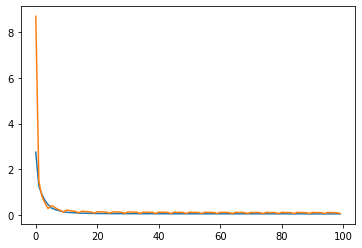

In [40]:

#Training
#Lambda = 0.2,0.4,0.6
a,b,q,p = SGD(it, nu, a, b, q, p, train_error, val_error, train_set,learning_rate = 0.05, lambda_val = 0, start_it = 0)
#Test


In [41]:
test_error(nu, a, b, q, p, test_set)

Test Error:
1.297855036172081
